#**MUFG Hackathon - Insurance Knowledge Graph with Semantic Search**

#**Project Overview**

This project builds a knowledge graph from insurance policy data and enables semantic search over it using FAISS and Sentence Transformers.

#**Objectives**


*   Load and clean insurance data from an Excel file
*   Construct a knowledge graph using NetworkX
*   Enable semantic querying of graph nodes and related subgraphs
*   Generate vector embeddings for graph nodes



#Upload Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset MUFG hacakthonxlsx.xlsx to dataset MUFG hacakthonxlsx.xlsx


#Install Dependencies

In [ ]:
!pip install networkx faiss-cpu sentence-transformers pandas openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

#Load and Clean Data + Build Graph

In [ ]:
import pandas as pd
import networkx as nx
import re

excel_file = list(uploaded.keys())[0]
sheet_name = "australia_insurance_extended_mo"

df = pd.read_excel(excel_file, sheet_name=sheet_name)

def clean_phone(p):
    if pd.isna(p): return ""
    return re.sub(r"[^\d+]", "", str(p))

def clean_email(e):
    if pd.isna(e): return ""
    return str(e).strip().lower()

df['Phone_clean'] = df['Phone'].apply(clean_phone)
df['Email_clean'] = df['Email'].apply(clean_email)
df['Annual Premium (AUD)'] = pd.to_numeric(df['Annual Premium (AUD)'], errors='coerce').fillna(0.0)
df['Claim Amount (AUD)'] = pd.to_numeric(df['Claim Amount (AUD)'], errors='coerce').fillna(0.0)
df['risk_score'] = df.apply(lambda r: (r['Claim Amount (AUD)'] / r['Annual Premium (AUD)']) if r['Annual Premium (AUD)']>0 else 0.0, axis=1)

G = nx.DiGraph()

for idx, row in df.iterrows():
    c_id = f"CUST_{idx}"
    p_id = f"POL_{row['Policy Number']}"
    a_id = f"AGENT_{re.sub(r'[^A-Za-z0-9]', '_', row['Agent Name']).upper()}"
    s_id = f"STATE_{row['State'].upper().replace(' ', '_')}"
    it_id = f"INS_{re.sub(r'[^A-Za-z0-9]', '_', row['Insurance Type']).upper()}"
    pt_id = f"PT_{re.sub(r'[^A-Za-z0-9]', '_', row['Product Tier']).upper()}"

    G.add_node(c_id, label='Customer', name=row['Customer Name'], age=int(row['Age']),
               email=row['Email_clean'], phone=row['Phone_clean'], state=row['State'])
    G.add_node(p_id, label='Policy', policy_number=row['Policy Number'], insurance_type=row['Insurance Type'],
               product_tier=row['Product Tier'], annual_premium=row['Annual Premium (AUD)'],
               claim_amount=row['Claim Amount (AUD)'], claim_status=row['Claim Status'],
               policy_start=str(row['Policy Start Date']), policy_end=str(row['Policy End Date']),
               risk_score=row['risk_score'])
    G.add_node(a_id, label='Agent', name=row['Agent Name'])
    G.add_node(s_id, label='State', name=row['State'])
    G.add_node(it_id, label='InsuranceType', name=row['Insurance Type'])
    G.add_node(pt_id, label='ProductTier', name=row['Product Tier'])

    G.add_edge(c_id, p_id, label='HAS_POLICY')
    G.add_edge(p_id, a_id, label='MANAGED_BY')
    G.add_edge(c_id, s_id, label='LIVES_IN')
    G.add_edge(p_id, it_id, label='TYPE_OF')
    G.add_edge(p_id, pt_id, label='PRODUCT_TIER')

nx.write_graphml(G, "mufg_insurance_graph.graphml")

#**Step 5: Generate Embeddings for Graph Nodes**

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import json

model = SentenceTransformer("all-MiniLM-L6-v2")

node_texts = []
node_ids = []
for n, attrs in G.nodes(data=True):
    desc = f"{attrs.get('label', '')} - " + ", ".join([f"{k}: {v}" for k,v in attrs.items() if k != "label"])
    node_texts.append(desc)
    node_ids.append(n)

embeddings = model.encode(node_texts, convert_to_numpy=True, normalize_embeddings=True)

dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeddings)

with open("id_map.json", "w") as f:
    json.dump({i: node_ids[i] for i in range(len(node_ids))}, f)

faiss.write_index(index, "graph_nodes.faiss")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#**Step 6: Query and Retrieve Subgraph**

In [ ]:
def retrieve_nodes(query, top_k=5):
    q_emb = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    scores, idxs = index.search(q_emb, top_k)
    results = []
    for score, idx in zip(scores[0], idxs[0]):
        n_id = node_ids[idx]
        results.append({
            "node_id": n_id,
            "score": float(score),
            "attributes": dict(G.nodes[n_id])
        })
    return results

def retrieve_subgraph(query, top_k=5):
    hits = retrieve_nodes(query, top_k)
    sub_nodes = set()
    for hit in hits:
        sub_nodes.add(hit["node_id"])
        sub_nodes.update(G.neighbors(hit["node_id"]))
        sub_nodes.update(G.predecessors(hit["node_id"]))
    return hits, G.subgraph(sub_nodes).copy()

query = "high risk health insurance policies in Queensland"
hits, subG = retrieve_subgraph(query)

print("Top hits:")
for h in hits:
    print(f"{h['node_id']} | score={h['score']:.4f} | {h['attributes']}")

Top hits:
INS_HEALTH | score=0.5030 | {'label': 'InsuranceType', 'name': 'Health'}
POL_POL3833694 | score=0.4795 | {'label': 'Policy', 'policy_number': 'POL3833694', 'insurance_type': 'Health', 'product_tier': 'Gold', 'annual_premium': 2712.32, 'claim_amount': 14505.84, 'claim_status': 'Rejected', 'policy_start': '2023-07-10 00:00:00', 'policy_end': '2024-08-25 00:00:00', 'risk_score': 5.348130014157621}
POL_POL4946275 | score=0.4776 | {'label': 'Policy', 'policy_number': 'POL4946275', 'insurance_type': 'Health', 'product_tier': 'Basic', 'annual_premium': 3869.47, 'claim_amount': 8798.91, 'claim_status': 'Rejected', 'policy_start': '2022-08-01 00:00:00', 'policy_end': '2023-06-20 00:00:00', 'risk_score': 2.273931572024076}
POL_POL4528608 | score=0.4773 | {'label': 'Policy', 'policy_number': 'POL4528608', 'insurance_type': 'Health', 'product_tier': 'Basic', 'annual_premium': 1941.84, 'claim_amount': 143.57, 'claim_status': 'Approved', 'policy_start': '2024-04-05 00:00:00', 'policy_end':

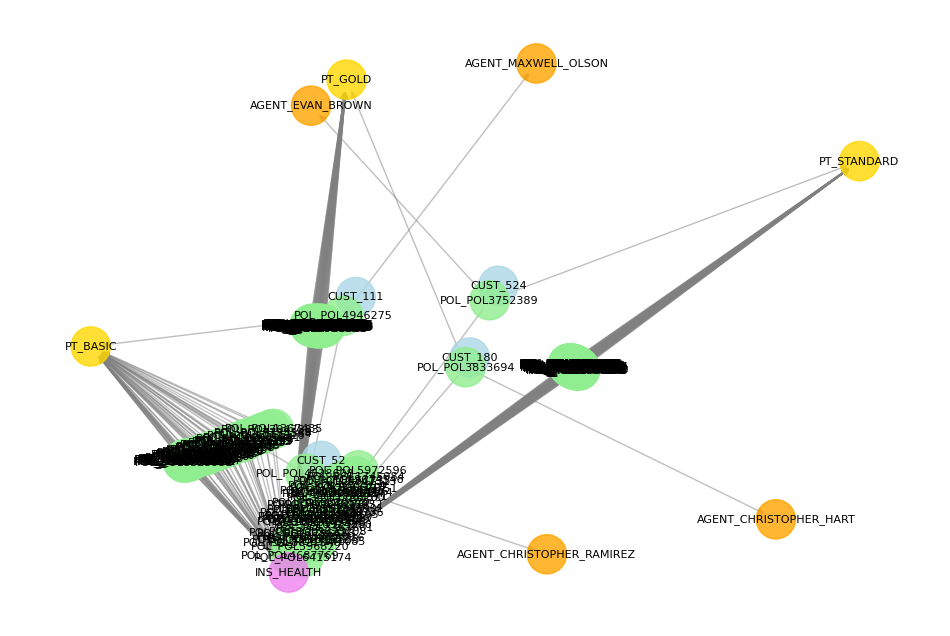

In [ ]:
import matplotlib.pyplot as plt

def visualize_subgraph(subgraph):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph, seed=42)

    # Node colors based on type
    node_colors = []
    for node in subgraph.nodes(data=True):
        label = node[1].get("label", "")
        if label == "Customer":
            node_colors.append("lightblue")
        elif label == "Policy":
            node_colors.append("lightgreen")
        elif label == "Agent":
            node_colors.append("orange")
        elif label == "State":
            node_colors.append("pink")
        elif label == "InsuranceType":
            node_colors.append("violet")
        elif label == "ProductTier":
            node_colors.append("gold")
        else:
            node_colors.append("gray")

    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=800, alpha=0.8)
    nx.draw_networkx_edges(subgraph, pos, edge_color="gray", alpha=0.5)
    nx.draw_networkx_labels(subgraph, pos, font_size=8, font_family="sans-serif")

    plt.axis("off")
    plt.show()

# Example: visualize retrieved subgraph
query = "high risk health insurance policies in Queensland"
matched_nodes = retrieve_nodes(query, top_k=5)
hits, retrieved_subgraph = retrieve_subgraph(query)
visualize_subgraph(retrieved_subgraph)